# Single Linear Regression with CAPM

The Capital Asset Pricing Model (CAPM) is a foundational model in finance that describes the relationship between the expected return and its associated risk of an asset. It shows that the expected return on a security is equal to the risk-free rate plus a risk premium, which is based on the beta of that security. Below is an illustration of the CAPM formula:

$R_a = R_f + \beta(R_m-R_f)$

Where:
- $R_a$: Expected return of an asset or portfolio.
- $R_f$ is the Risk-free rate return, usually the return of an AAA Treasury Bond
- $R_m$ is the expected market return
- $\beta$: Beta coefficient of the asset or portfolio related to the market. it measures the sensitivity of an asset's returnsvrelative to its market.

This formula reminds of a linear model where:

$y=b+mx$

Here, $m$ is the slope of the line and $b$ its intersect while $y$ and $x$ are the dependent and independent variable respectively.

---

## CAPM relevance

The CAPM formula is widely used in the finance industry. It is vital in calculating the Weighted Average Cost of Capital (WACC), as CAPM equals the cost of equity.

WACC is used extensively in financial modeling.  It can be used to find the net present value (NPV) of the future cash flows of an investment and to further calculate its enterprise value and, finally, its equity value.

By understanding CAPM, analysts can evaluate the risk-adjusted returns of an asset and make more informed investment decisions.

---


## Project Overview

The following project is focused on applying a CAPM model for Microsoft Stocks and comparing its returns with those of the Standard & and Poors 500.

The primary objectives include:

- Model Fitting: Construct a CAPM model using historical stock and market data.
- Prediction: Predict future returns of Microsoft stock based on historical returns and volatility.
- Evaluation: Assess the fit of the model and determine whether Microsoft's returns consistently outperform (or underperform) the market benchmark.
- Statistical Significance: Analyze whether the observed differences between the market and asset returns are statistically significant or occur by chance.


We will use Python to build such a model. However, no Machine learning libraries such as Scikit Learn or Statsmodel will be imported for the project. The primary goal is to apply the mathematical fundamentals of a linear regression model. Instead, we will build the model from scratch, implementing all calculations manually to deepen our understanding of the underlying concepts.

Without further ado, let us begin with our first project of the series.
The first step will be to import the neccesary libraries to start working.

In [1]:
import requests
from google.colab import userdata
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
from math import sqrt

# Data retrieval from Alpha Vantage API

Alpha Vantage is a free to use API which provides access to a wide variety of data including stock prices and US treasury bills which will be used for this project.

For more information about the tool, check the [Alpha Vantage documentation](https://www.alphavantage.co/documentation/).

The data retrieved for this project will be the daily Microsoft stock closing prices, SPY ETF daily prices which replicates the S&P 500 index and the US treasury bills rates of returns.

The Following code will define the needed functions for the API calls which will get the data previously stated. Please note that any API call requires an [API key](https://www.alphavantage.co/support/#api-key) in order to properly access the data needed.

---

In [2]:
def get_data(API_KEY, function, symbol, outputsize='full'):
  url = f'https://www.alphavantage.co/query?function={function}&outputsize={outputsize}&symbol={symbol}&interval=5min&apikey={API_KEY}'
  response = requests.get(url)
  data = response.json()
  return data

def get_risk_free_rate(API_KEY,function='TREASURY_YIELD',interval='daily', maturity= '10year'):
  url = f'https://www.alphavantage.co/query?function={function}&interval={interval}&maturity={maturity}&apikey={API_KEY}'
  response = requests.get(url)
  data = response.json()
  return data

In [3]:
# Insert your API Key
API_KEY = userdata.get('API_KEY_AV')

Once obtained the API key and prepared the URLs for the call, it is time to transform the data into a pandas dataframe format. The following class will use the API calls class to query the data in JSON format, select only the closing prices for our asset and benchmark and return a dataframe with said information along the treasury rates.

Once obtained the closing prices it is required to compute the percentage changes in order to obtain the returns of both Microsoft shares and the SPY ETF.

The Risk free returns are to be transformed into daily returns as the values are given annualized.

In [4]:
class Pipeline:
  def __init__(self, asset, market):
    self._asset = asset
    self._market = market

  def daily_time_series(self):
    '''This Method creates an API call object for a given asset and market benchmark and returns a dataframe
    with their daily prices'''
    asset_data = get_data(API_KEY,function='TIME_SERIES_DAILY',symbol=self._asset)
    market_data = get_data(API_KEY, function= 'TIME_SERIES_DAILY', symbol= self._market)
    df_asset = pd.DataFrame(asset_data['Time Series (Daily)']).T.sort_index()['4. close'].reset_index().rename(columns={'index':'date', '4. close': self._asset})
    df_market = pd.DataFrame(market_data['Time Series (Daily)']).T.sort_index()['4. close'].reset_index().rename(columns={'index':'date', '4. close': self._market})
    df = df_asset.merge(df_market)
    return df

  def treasury_yields(self):
    '''The above method queries the US trasury yield for 10 years maturity for daily interval'''
    data = get_risk_free_rate(API_KEY)
    df = pd.DataFrame(data['data']).sort_values(by='date').rename(columns={'value': 'RiskFreeRate'})
    return df

  def transform_dtypes(self):
    '''This method cleans and transforms the data obtained changing the daily prices into returns.
    The risk-free rate is changed from annual to daily return'''
    data = self.daily_time_series()
    risk_free = self.treasury_yields()
    df = data.merge(risk_free)

    df['date'] = pd.to_datetime(df['date'])
    df[self._asset] = pd.to_numeric(df[self._asset]).pct_change()
    df[self._market] = pd.to_numeric(df[self._market]).pct_change()
    df['RiskFreeRate']= df['RiskFreeRate'].apply(lambda x: np.nan if x == '.' else x)
    df['RiskFreeRate'] = pd.to_numeric(df['RiskFreeRate']).ffill()
    df['RiskFreeRate'] = ((1 + df['RiskFreeRate'] / 100) ** (1/252) -1)
    df = df.dropna()
    return df

In [23]:
df = Pipeline('MSFT','SPY').transform_dtypes()
df.head()

,date,MSFT,SPY,RiskFreeRate
1,1999-11-02,0.002057,-0.007147,0.000233
2,1999-11-03,-0.006050,0.006734,0.000232
3,1999-11-04,-0.002717,0.007610,0.000229
4,1999-11-05,-0.002071,0.009842,0.000228
5,1999-11-08,-0.017693,0.000907,0.000229


In [24]:
df.describe()

,date,MSFT,SPY,RiskFreeRate
count,6455,6455.000000,6455.000000,6455.000000
mean,2012-08-31 14:05:29.047250176,0.000468,0.000311,0.000129
min,1999-11-02 00:00:00,-0.483230,-0.109424,0.000021
25%,2006-04-04 12:00:00,-0.008175,-0.004845,0.000088
50%,2012-08-29 00:00:00,0.000353,0.000637,0.000132
75%,2019-01-30 12:00:00,0.009401,0.005996,0.000168
max,2025-07-02 00:00:00,0.195749,0.145198,0.000261
std,NaN,0.020012,0.012297,0.000051


# Exploring the data

The next step is to plot histograms of our daily returns.

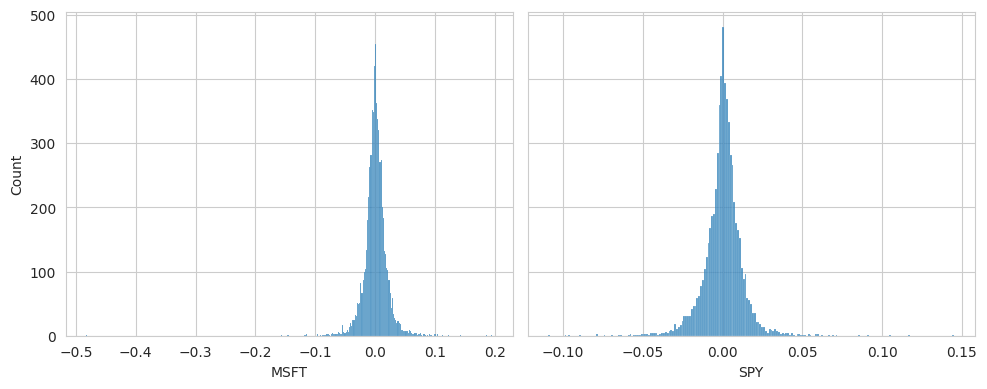

In [26]:
fig,ax = plt.subplots(1,2, figsize=(10,4), sharey=True)

sns.histplot(df, x='MSFT', ax=ax[0])
sns.histplot(df, x='SPY', ax=ax[1])
plt.tight_layout()
plt.show()

Both Microsoft and the S&P 500 seem to follow a normal distribution. The next chart showcases the cumulative returns over time (compounded) of both assets.

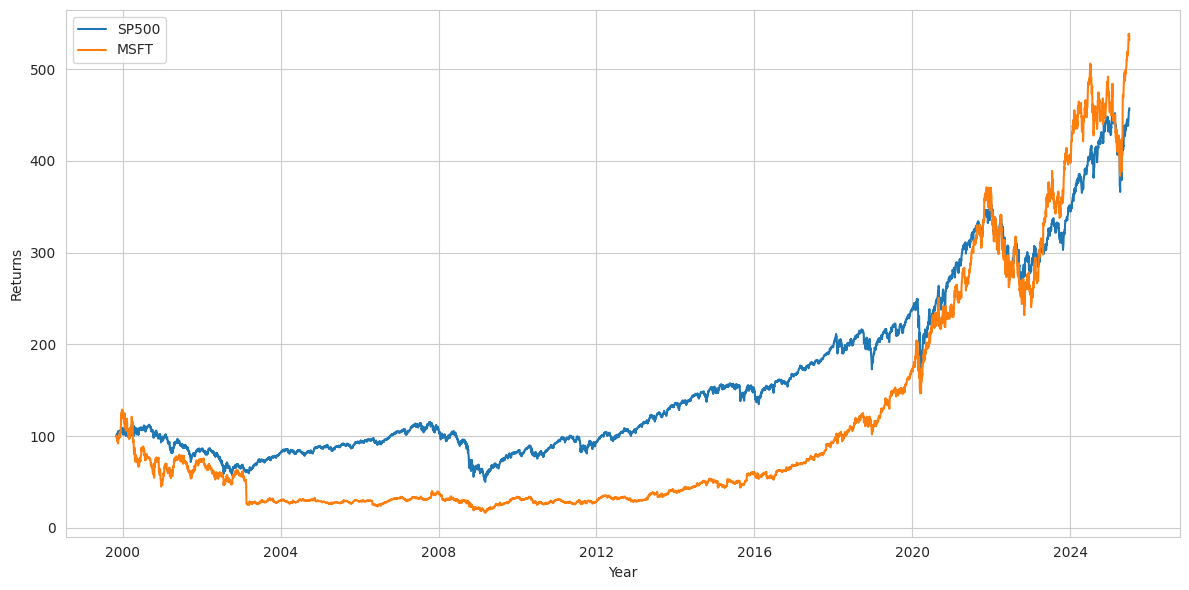

In [27]:
plt.figure(figsize=(12, 6))

sns.lineplot(x=df['date'], y=100 * (np.cumprod(1 +df['SPY'])), label ='SP500')
sns.lineplot(x=df['date'], y=100 * (np.cumprod(1 +df['MSFT'])), label ='MSFT')

plt.ylabel('Returns')
plt.xlabel('Year')
plt.tight_layout()
plt.legend()
plt.show()

Both our asset and bechmark seem to be somewhat positively correlated.

The next step is to calculate our risk premium ($R_m-R_f$) and $R_a-R_f$ in order to establish our linear equation:

$R_a-R_f= α + β(R_m-R_f)$

Where $α$ is the intercept of a linear regression.


In [28]:
df['msft_adj'] = df['MSFT']-df['RiskFreeRate']
df['market_adj'] = df['SPY']-df['RiskFreeRate']

df.head()

,date,MSFT,SPY,RiskFreeRate,msft_adj,market_adj
1,1999-11-02,0.002057,-0.007147,0.000233,0.001824,-0.007379
2,1999-11-03,-0.006050,0.006734,0.000232,-0.006282,0.006502
3,1999-11-04,-0.002717,0.007610,0.000229,-0.002947,0.007381
4,1999-11-05,-0.002071,0.009842,0.000228,-0.002299,0.009614
5,1999-11-08,-0.017693,0.000907,0.000229,-0.017923,0.000677


The following class computes the descriptive statistics of a given dataset. In order to calculate the $\beta$, the covariance between the market returns and the asset returns are needed as well as the market variance.

$\beta=\frac{cov(x,y)}{var(x)}=\frac{(x_i-\overline{x})(y_i-\overline{y})}{(x_i-\overline{x})²}$



In [9]:
class Statistics:

    @staticmethod
    def mean(x):
      return sum(x)/len(x)

    @staticmethod
    def variance(x):
      mean_x = Statistics.mean(x)
      result = ((x-mean_x)**2)
      return Statistics.mean(result)

    @staticmethod
    def standard_deviation(x):
      return np.sqrt(Statistics.variance(x))

    @staticmethod
    def covariance(x,y):
      mean_x = Statistics.mean(x)
      mean_y = Statistics.mean(y)

      result = ((x-mean_x)*(y-mean_y))
      return Statistics.mean(result)

    @staticmethod
    def simple_linear_regression(x,y):
      mean_x = Statistics.mean(x)
      mean_y = Statistics.mean(y)
      cov_xy = Statistics.covariance(x,y)
      var_x = Statistics.variance(x)

      beta = cov_xy/var_x
      alpha = mean_y - beta*mean_x

      return alpha, beta

    @staticmethod
    def Sharpe_Ratio(asset, rf):
      r = Statistics.mean(asset-rf)
      s = Statistics.standard_deviation(asset)
      return r/s


Another crucial metric that should not be overlooked is the Sharpe's Ratio. This ratio is the relation between the the expected return and the market volatility, the greater the number, the better.

$S=\frac{R_a-R_f}{σ_a}$

In [10]:
sharpe_msft = Statistics.Sharpe_Ratio(df['MSFT'], df['RiskFreeRate'])
sharpe_spy = Statistics.Sharpe_Ratio(df['SPY'], df['RiskFreeRate'])

print(f'MSFT Sharpe Ratio: {sharpe_msft}\nSP500 Sharpe Ratio: {sharpe_spy}')

MSFT Sharpe Ratio: 0.016933676257640605
SP500 Sharpe Ratio: 0.01479262169882293


Both Sharpe's ratios are almost equals, meaning that the risk-return relations are similar.

In [11]:
alpha, beta = Statistics.simple_linear_regression(df['market_adj'].to_numpy(),df['msft_adj'].to_numpy())
print(f'Alpha: {alpha}\nBeta: {beta}')

Alpha: 0.0001434646542341472
Beta: 1.0742538493034846


Microsoft stocks beta is slightly more volatile than the SP 500 ETF. The alpha value is close to zero, meaning that the returns of both assets are almost the same.

Let us apply the CAPM formula to obtain the expected returns for our selected asset.

In [29]:
df['CAPM'] = df['RiskFreeRate'] + beta * df['market_adj']
df['alpha'] = df['MSFT']-df['CAPM']

print(f"Average alpha: {Statistics.mean(df['alpha'])}")
df.head()

Average alpha: 0.00014346465423414678


,date,MSFT,SPY,RiskFreeRate,msft_adj,market_adj,CAPM,alpha
1,1999-11-02,0.002057,-0.007147,0.000233,0.001824,-0.007379,-0.007694,0.009751
2,1999-11-03,-0.006050,0.006734,0.000232,-0.006282,0.006502,0.007216,-0.013267
3,1999-11-04,-0.002717,0.007610,0.000229,-0.002947,0.007381,0.008158,-0.010876
4,1999-11-05,-0.002071,0.009842,0.000228,-0.002299,0.009614,0.010556,-0.012627
5,1999-11-08,-0.017693,0.000907,0.000229,-0.017923,0.000677,0.000957,-0.018650


Note that the difference between the expected return given by the CAPM and the actual returns from the asset is almost equal to the intersect of our linear regression.

A higher alpha means a higher chance that the asset performs better than the market. If $α<0$ it means that the asset performs worse than the benchmark.

Another way to compare our benchmark and the expected returns of our asset is by the geometric mean of the rates of returns over the given period. This way it is possible to include the compounding effect in our portfolio.

$GM = \sqrt[n]{\prod_{i}^{n}1+R_i}-1$


In [30]:
gmean = ((1+df['CAPM']).prod())**(1/len(df['CAPM']))-1
print(f'MSFT expected annual return: {round(((1+gmean)**252-1)*100,2)}%')

gmean = ((1+df['SPY']).prod())**(1/len(df['SPY']))-1
print(f'SP 500 expected annual return: {round(((1+gmean)**252-1)*100,2)}%')

MSFT expected annual return: 6.17%
SP 500 expected annual return: 6.12%


Microsoft annualized expected rate of return is slightly higher than that of the SP 500. However, the final way to compare the asset return with the benchmark is by Hipothesis testing the alpha value.

With this aproach it will be possible to asses wether the stock is able to consistently beat the market or if the higher return is just a product of sheer luck.

The following code will perform parametric and non-parametric test to reject or not the null hipothesis that for $H_0:α=0$ and for $H_1:α\neq0$. The critical value threshold will be 5%.

In [46]:
se = Statistics.standard_deviation(df['alpha']) /sqrt(len(df['alpha']))
t_stat = Statistics.mean(df['alpha'])/se
print(f't-score: {t_stat}')

t-score: 0.7667484907154524


The p-value for our t-score is aproximately 0.44. Which is higher than the critical value 0.05. It is posible to compute the full test using the stat package from Scipy as follows:

In [50]:
stat, pvalue = stats.ttest_1samp(df['alpha'], popmean=0)
print(f'Student-t test\nt-score: {stat}\np-value: {pvalue}')

Student-t test
t-score: 0.7666890965877287
p-value: 0.4432944302164955


The Student-t test assumes normal distribution, therefore it is a parametric test. The p-value of said test is over .443. Therefore, we fail to reject our null hipothesis and assume that Microsoft Stocks does not overperform the market.

---


# Model Evaluation

The following task is to plot the results of the model with the actual returns of Microsoft shares.

The next chart represents the actual (red) and predicted (blue) returns over time.

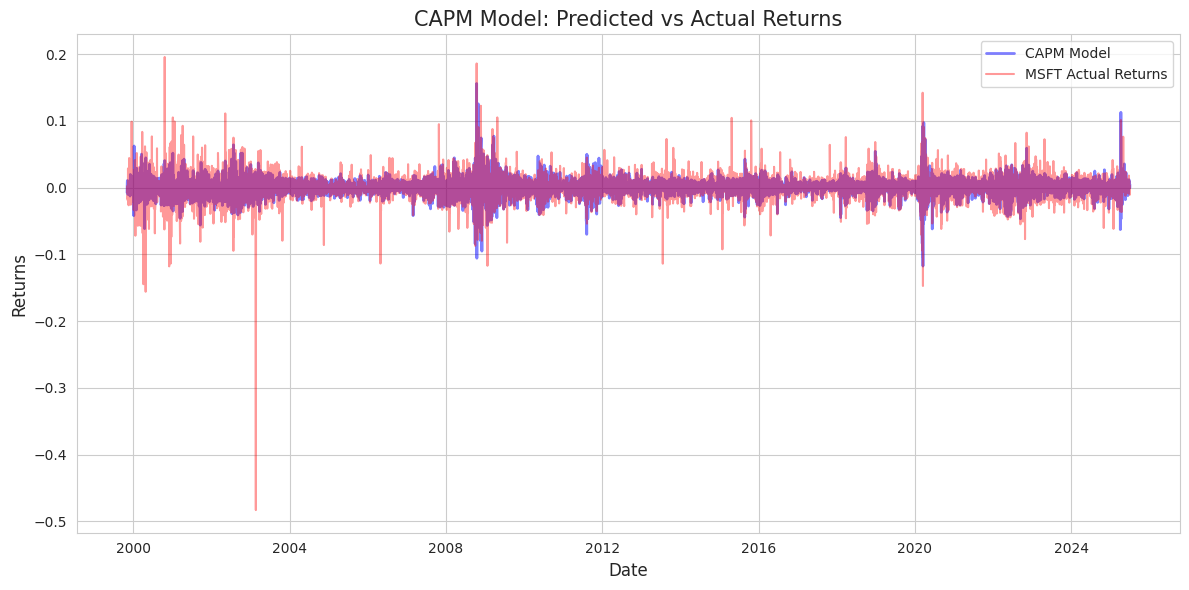

In [15]:
plt.figure(figsize=(12, 6))
sns.set_style("whitegrid")

sns.lineplot(x=df['date'],y=df['CAPM'], label='CAPM Model', color='blue', linewidth=2,alpha=0.5)
sns.lineplot(x=df['date'],y=df['MSFT'], label='MSFT Actual Returns', color='red', alpha=0.4)

plt.title('CAPM Model: Predicted vs Actual Returns', fontsize=15)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Returns', fontsize=12)
plt.legend()

plt.tight_layout()
plt.show()

Although the actual returns tend to be more volatile and subjects to outliers, the model seems to visually explain the variance of the asset.

Other way to asess the fit of our model is by plotting a scatter plot along the Security Market Line or regression line.

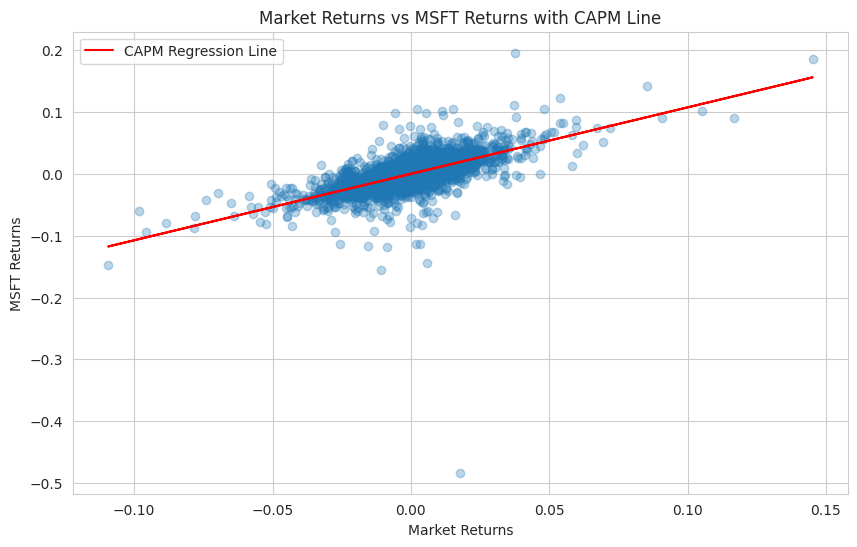

In [16]:
plt.figure(figsize=(10, 6))
plt.scatter(df['SPY'], df['MSFT'], alpha=0.3)
plt.plot(df['SPY'], df['CAPM'], color='red', label='CAPM Regression Line')
plt.title('Market Returns vs MSFT Returns with CAPM Line')
plt.xlabel('Market Returns')
plt.ylabel('MSFT Returns')
plt.legend()
plt.show()

It is possible to see a positive correlation between the asset and the market. Data points are well grouped with exception of some outliers, and the SML seems to follow the trend.

The next way to evaluate the model is with the use of residual metrics and the R² Coeficient.

First, it is recomended to compute all the error estimation. For instance, the formula for the R² is the following:

$R²=1-\frac{SSR}{SST}$

where

$SSR=\sum_{i=1}^{n}(y_i-\hat{y})$
and
$SST=\sum_{i=1}^{n}(y_i-\overline{y})$

SSR stands for the Sum of Squares of Residuals, being the residual the difference between the actual value and the predicted value. SST is the Sum of Squares of the total.

Other relevant measures that could be useful uppon using our model for prediction purposes are the errors. For instance:

Mean Absolute Error or $MAE=\frac{1}{n}\sum_i^n|y-\hat{y}|$

Mean Square Error or $MSE= \frac{SSR}{n} =\frac{1}{n}\sum_{i=1}^{n}(y_i-\hat{y}) $

Root Mean Square Error or $RMSE=\sqrt{MSE}= \sqrt{\frac{1}{n}\sum_{i=1}^{n}(y_i-\hat{y})}$


In [17]:
def get_r2_coef(actual_values, predicted_values):

    SR = sum((actual_values-predicted_values)**2)
    St = sum((actual_values- Statistics.mean(actual_values))**2)
    r_2 = 1-(SR/St)

    return r_2

def get_errors(actual_values, predicted_values):
      n= len(actual_values)
      SR = sum((actual_values-predicted_values)**2)
      MAE = Statistics.mean(abs(actual_values-predicted_values))
      MSE = SR/n
      RMSE = sqrt(MSE)


      return {'SR':SR,'MAE':MAE,'MSE':MSE,'RMSE': RMSE}

r_2 = get_r2_coef(df['MSFT'],df['CAPM'])
print(f'R² Coeficient: {r_2}\n')
errors = get_errors(df['MSFT'], df['CAPM'])
print('Error Metrics')
display(errors)

R² Coeficient: 0.43560170269800846

Error Metrics


{'SR': 1.458868066777552,
 'MAE': 0.008922302646417876,
 'MSE': 0.00022600589725446196,
 'RMSE': 0.015033492516859212}

R² Coeficient is approximately 0.436. Meaning that the model is capable of explaining at least a 43.6% of the change of returns with only the systematic risk taken into account.

The error metric MSE (Mean Square Error) will be used to stablish a confidence and a prediction interval for our model.

Where

The Confidence Interval or $CI = \hat{y_i}\pm t_{crit}\sqrt{MSE(\frac{1}{n}+\frac{(x_i-\overline{x})²}{SS_{x}})}$

The Prediction Interval or $PI=\hat{y_i}\pm t_{crit}\sqrt{MSE(1+\frac{1}{n}+\frac{(x_i-\overline{x})²}{SS_{x}})}$

The critical value $t$ is dependant on the confidence level required for our problem. For this case case we are aiming for a 95% level.

therefore, for a t distribution $t_{crit} = 1.96$

In [18]:
def confidence_bound(MSE,x):
  x = np.array(x)
  n = len(x)
  x_mean = Statistics.mean(x)

  bound = 1.96 *np.sqrt(MSE*(1/n + (((x-x_mean)**2))/np.sum((x - x_mean)**2)))
  return bound


def prediction_bound(MSE,x):
  x = np.array(x)
  n = len(x)
  x_mean = Statistics.mean(x)

  bound = 1.96 *np.sqrt(MSE*(1+ 1/n + (((x-x_mean)**2))/np.sum((x - x_mean)**2)))
  return bound

In [19]:
CI = confidence_bound(errors['MSE'], df['SPY'])
PI = prediction_bound(errors['MSE'], df['SPY'])

print(f'Confidence Interval Array: {CI}')
print()
print(f'Prediction Interval Array: {PI}')

Confidence Interval Array: [0.00042894 0.00041376 0.0004265  ... 0.00039023 0.00036724 0.00038777]

Prediction Interval Array: [0.02946877 0.02946855 0.02946873 ... 0.02946823 0.02946793 0.0294682 ]


A simpler way to compute these intervals is by using the standard deviation of the residuals. For example:

$CI=t_{crit}\cdot(\frac{σ_ϵ}{\sqrt{n}})$

$PI=t_{crit}\cdot σ_ϵ\sqrt{1+\frac{1}{n}}$

In [20]:
def confidence_bound(MSE,x):
  x = np.array(x)
  n = len(x)
  s = Statistics.standard_deviation(x)
  x_mean = Statistics.mean(x)

  bound = 1.96 * (s/np.sqrt(n))
  return bound


def prediction_bound(MSE,x):
  x = np.array(x)
  n = len(x)
  x_mean = Statistics.mean(x)
  s = Statistics.standard_deviation(x)

  bound = 1.96 *s*np.sqrt(1+(1/n))
  return bound

In [21]:
CI = confidence_bound(errors['MSE'], df['alpha'])
PI = prediction_bound(errors['MSE'], df['alpha'])

print(f'CI: {CI}, PI: {PI}')

CI: 0.00036673136720040867, PI: 0.029466585797579683


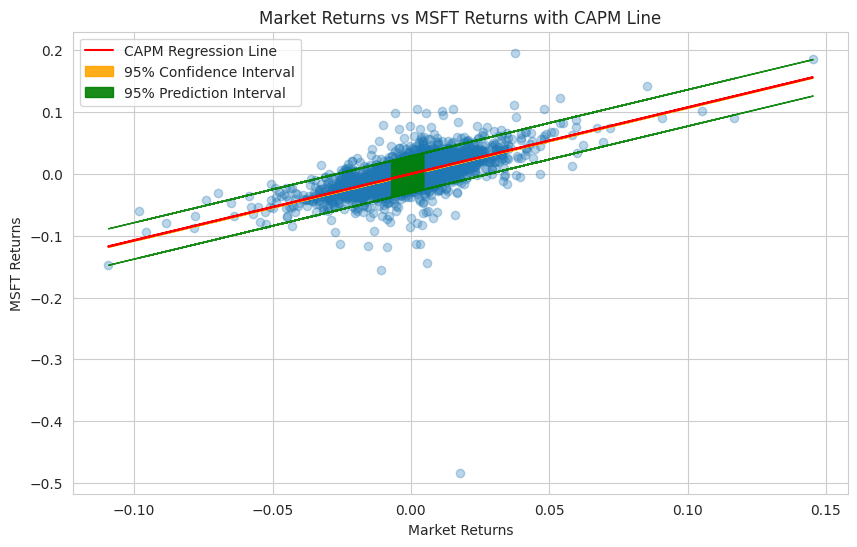

In [22]:
plt.figure(figsize=(10, 6))
plt.scatter(df['SPY'], df['MSFT'], alpha=0.3)
plt.plot(df['SPY'], df['CAPM'], color='red', label='CAPM Regression Line')


plt.fill_between(df['SPY'], df['CAPM'] + CI, df['CAPM']-CI, color='orange', label='95% Confidence Interval', alpha=0.9)
plt.fill_between(df['SPY'], df['CAPM'] + PI, df['CAPM']-PI, color='green', label='95% Prediction Interval', alpha=0.9)

plt.title('Market Returns vs MSFT Returns with CAPM Line')
plt.xlabel('Market Returns')
plt.ylabel('MSFT Returns')
plt.legend()
plt.show()

By adding a prediction interval, it is possible to establish a range of possible outcomes for our prediction with a 95% confidence level.

# Final Conclusions

This project successfully demonstrated the application of the Capital Asset Pricing Model, which uses linear regression as its foundational framework. The process began by retrieving real-world financial data via the Alpha Vantage API, followed by cleaning and transforming the data to make it suitable for analysis.

Once the data was prepared, we visualized it by plotting histograms of daily returns and cumulative returns over the analysis period. There we could learn that both (asset and market) distributions seemed to follow a normal distribution from a visual point of view. Risk and Reward ratio were almost equal, even if Microsoft slightly outperformed the market.

After a minor exploration it was time to fit our linear regression model from scratch and computed the $β$ coefficient as the slope and α as the intersect. We used the CAPM formula to predict the asset return values and proofed that the intersect from our line is equal to the mean of the residuals of our CAPM.

An Hipothesis testing was performed in order to assess wether the asset performs any differently from our benchmark. The results were that both performed similarly.

The final task was to evaluate our model by using relevant metrics to test its fitting. Our R² coeficient was aproximately 0.43, meaning there might by other variables that explain the asset performance, although it was a great start. We could also compute different error measures in order to establish a confidence and prediction interval for a 95% confidence level.

Overall, the project achieved its primary objectives. By building a linear regression model from scratch, we gained a deeper understanding of CAPM and demonstrated its ability to predict future returns based on market performance.

## Limitations

While the CAPM is a widely used and foundational model in finance, it has several limitations:

- Focus on Systematic Risk: The model only considers market or systematic risk, ignoring unsystematic (company-specific) risk.
- Linear Relationship Assumption: CAPM assumes a linear relationship between risk and return.
- Investor Behavior and Market Efficiency: The model relies on assumptions that all investors are risk-averse and that markets are perfectly efficient.
- Single-Factor Model: CAPM is a single-factor model, meaning it does not account for other potential influences on asset performance, such as macroeconomic factors or company-specific events.

Due to many assumptions have been challenged, several alternative models have been developed to understand the relationship between risk and reward in investments. One of these is arbitrage pricing theory (APT), a model that looks at multiple factors, grouped into macroeconomic or company-specific factors.

### Bibliography

- Corporate Finance Institute.  *What is CAPM Formula?*. Retrieved from [https://corporatefinanceinstitute.com/resources/valuation/what-is-capm-formula/](https://corporatefinanceinstitute.com/resources/valuation/what-is-capm-formula/)

- Investopedia.  *Capital Asset Pricing Model (CAPM)*. Retrieved from [https://www.investopedia.com/terms/c/capm.asp](https://www.investopedia.com/terms/c/capm.asp)

- Investopedia.  *Sharpe Ratio*. Retrieved from [https://www.investopedia.com/terms/s/sharperatio.asp](https://www.investopedia.com/terms/s/sharperatio.asp)

- Investopedia.  *Annualized Total Return*. Retrieved from [https://www.investopedia.com/terms/a/annualized-total-return.asp](https://www.investopedia.com/terms/a/annualized-total-return.asp)

- GeeksforGeeks. *Regression Metrics in Machine Learning*. Retrieved from [https://www.geeksforgeeks.org/machine-learning/regression-metrics/](https://www.geeksforgeeks.org/machine-learning/regression-metrics/)

- DataCamp. *Confidence Intervals vs. Prediction Intervals*. Retrieved from [https://www.datacamp.com/blog/confidence-intervals-vs-prediction-intervals](https://www.datacamp.com/blog/confidence-intervals-vs-prediction-intervals)

- GeeksforGeeks. *Prediction Interval vs. Confidence Interval*. Retrieved from [https://www.geeksforgeeks.org/maths/prediction-interval-vs-confidence-interval/](https://www.geeksforgeeks.org/maths/prediction-interval-vs-confidence-interval/)
